In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot
from tqdm import tqdm

import tempfile
import os


[]

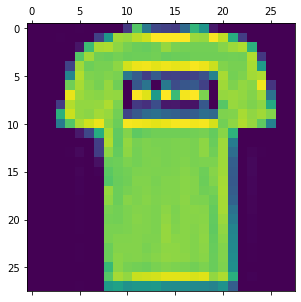

In [2]:
# Load MNIST dataset
mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

plt.matshow(train_images[1])
plt.plot()


In [43]:
# naive, with just dense layers
initial_layers1 = [keras.layers.InputLayer(input_shape=(28, 28)),
                  keras.layers.Reshape(target_shape=(28, 28, 1)),
                  keras.layers.Flatten(),
                  keras.layers.Dense(10)]

# added convolution and maxpooling
initial_layers2 = [keras.layers.InputLayer(input_shape=(28, 28)),
                  keras.layers.Reshape(target_shape=(28, 28, 1)),
                  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
                  keras.layers.MaxPooling2D(pool_size=(2, 2)),
                  keras.layers.Flatten(),
                  keras.layers.Dense(10)]

# added dense layer for greater parameters and better classification
initial_layers3 = [keras.layers.InputLayer(input_shape=(28, 28)),
                  keras.layers.Reshape(target_shape=(28, 28, 1)),
                  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
                  keras.layers.MaxPooling2D(pool_size=(2, 2)),
                  keras.layers.Flatten(),
                  keras.layers.Dense(128, activation='relu'),
                  keras.layers.Dense(10)]                

# Define the model architecture.
model = keras.Sequential(initial_layers3)

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

model.fit(
    train_images,
    train_labels,
    epochs=1,
    validation_split=0.25,
)


1407/1407 [==============================] - 11s 8ms/step - loss: 0.4474 - accuracy: 0.8431 - val_loss: 0.3260 - val_accuracy: 0.8843


In [4]:
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer


class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    # Configure how to quantize weights.
    def get_weights_and_quantizers(self, layer):
        return [(layer.kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
        return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
        # Add this line for each item returned in `get_weights_and_quantizers`
        # , in the same order
        layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
        # Add this line for each item returned in `get_activations_and_quantizers`
        # , in the same order.
        layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
        return []

    def get_config(self):
        return {}


In [10]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

all_qat_models = []
rng = range(4, 17)

for n_bits in tqdm(rng):
    class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):

        # Configure weights to quantize with n-bit instead of 8-bits.
        def get_weights_and_quantizers(self, layer):
            return [(layer.kernel, LastValueQuantizer(num_bits=n_bits, symmetric=True, narrow_range=False, per_axis=False))]

    def apply_quantization_to_dense(layer):
        if type(layer) in [keras.layers.InputLayer, keras.layers.Conv2D, keras.layers.Dense]:
            return quantize_annotate_layer(layer, ModifiedDenseQuantizeConfig())
        return layer

    model = keras.Sequential(initial_layers1)

    annotated_model = tf.keras.models.clone_model(
        model,
        clone_function=apply_quantization_to_dense,
    )

    qat_model = quantize_annotate_model(annotated_model)

    # `quantize_apply` requires mentioning `ModifiedDenseQuantizeConfig` with `quantize_scope`:
    with quantize_scope(
            {'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
        # Use `quantize_apply` to actually make the model quantization aware.
        qat_model = tfmot.quantization.keras.quantize_apply(qat_model)

    qat_model.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(
                                from_logits=True),
                            metrics=['accuracy'])

    qat_model.fit(
        train_images,
        train_labels,
        epochs=1,
        validation_split=0.25,
        verbose=0
    )

    all_qat_models.append(qat_model)

all_qat_models[0].summary()

100%|██████████| 13/13 [02:53<00:00, 13.38s/it]

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_13 (Quantize  (None, 28, 28)           3         
 Layer)                                                          
                                                                 
 quant_reshape_1 (QuantizeWr  (None, 28, 28, 1)        1         
 apperV2)                                                        
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 26, 26, 12)       125       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 13, 13, 12)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_flatten_1 (QuantizeWr  (None, 2028)           

In [73]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
_, baseline_model_accuracy = model.evaluate(test_images, test_labels, verbose=0)
all_qat_accs = []

for qat_model in all_qat_models:
    _, qat_model_accuracy = qat_model.evaluate(test_images, test_labels, verbose=0)
    all_qat_accs.append(round(qat_model_accuracy, 4))

print(f"Model Test Accuracy (without Quantization) \t: {baseline_model_accuracy}")
print(f"QAT Models Test Accuracy (without Quantization) : \n{all_qat_accs}")


Model Test Accuracy (without Quantization) 	: 0.8837000131607056
QAT Models Test Accuracy (without Quantization) : 
[0.8701, 0.8666, 0.8727, 0.8686, 0.873, 0.8698, 0.875, 0.8741, 0.8717, 0.8772, 0.8753, 0.8774, 0.8781]


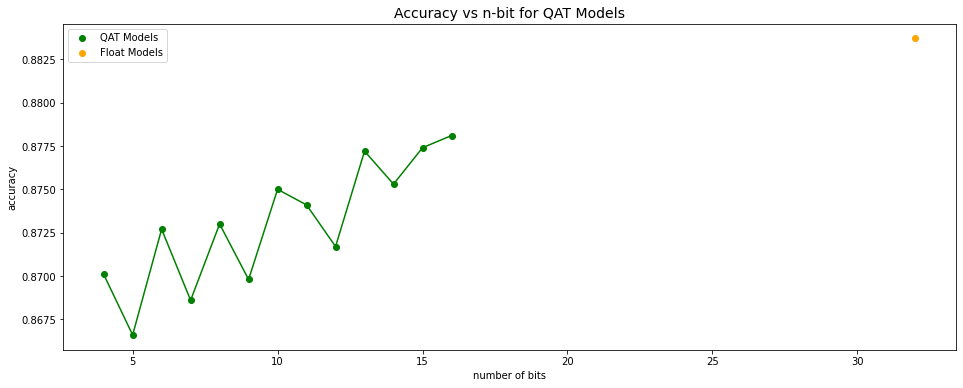

In [75]:
plt.figure(figsize=(16, 6))
plt.title('Accuracy vs n-bit for QAT Models', fontsize=14)
plt.plot(rng, all_qat_accs, color='green')
plt.scatter(rng, all_qat_accs, color='green', label='QAT Models')
plt.scatter([32], baseline_model_accuracy, color='orange', label='Float Models')
plt.xlabel('number of bits')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [56]:
d = {'Models':['Float Model']+[f'{n}-bit QAT Model' for n in rng], 'Accuracies':[baseline_model_accuracy]+all_qat_accs}
table = pd.DataFrame(d)

table

,Models,Accuracies
0,Float Model,0.8837
1,4-bit QAT Model,0.8701
2,5-bit QAT Model,0.8666
3,6-bit QAT Model,0.8727
4,7-bit QAT Model,0.8686
5,8-bit QAT Model,0.8730
6,9-bit QAT Model,0.8698
7,10-bit QAT Model,0.8750
8,11-bit QAT Model,0.8741
9,12-bit QAT Model,0.8717


In [59]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()
float_model_size = len(float_tflite_model) / float(2**20)

converter = tf.lite.TFLiteConverter.from_keras_model(all_qat_models[0])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

float_model_size = len(float_tflite_model) / float(2**20)
qat_model_size = len(quantized_tflite_model) / float(2**20)

INFO:tensorflow:Assets written to: C:\Users\YASHMA~1\AppData\Local\Temp\tmpd4xac7gy\assets


INFO:tensorflow:Assets written to: C:\Users\YASHMA~1\AppData\Local\Temp\tmpd4xac7gy\assets


INFO:tensorflow:Assets written to: C:\Users\YASHMA~1\AppData\Local\Temp\tmpay3y3gec\assets


INFO:tensorflow:Assets written to: C:\Users\YASHMA~1\AppData\Local\Temp\tmpay3y3gec\assets


In [81]:

print(f"Float model size \t: {float_model_size:.4f} mb")
print(f"8-bit QAT Model size \t: {qat_model_size:.4f} mb")

Float model size 	: 0.9174 mb
8-bit QAT Model size 	: 0.0233 mb


In [65]:
def evaluate_model(model):
    interpreter = tf.lite.Interpreter(model_content=model)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy


In [82]:
quantized_tflite_model_accuracy = evaluate_model(quantized_tflite_model)
float_tflite_model_accuracy = evaluate_model(float_tflite_model)


print(f"Float TFLite test_accuracy (without Quantization) \t : {float_tflite_model_accuracy}")
print(f"QAT TFLite test_accuracy (with 8-bit Quantization) \t : {quantized_tflite_model_accuracy}")


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Float TFLite test_accuracy (without Quantization) 	 : 0.8772
QAT TFLite test_accuracy (with 8-bit Quantization) 	 : 0.8442
